In [ ]:
import pandas as pd
import numpy as np
import multiprocessing as mp
from collections import defaultdict

np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import causalml
from causalml.metrics import plot_gain, plot_qini, qini_score
from causalml.dataset import synthetic_data
from causalml.inference.tree import plot_dist_tree_leaves_values, get_tree_leaves_mask
from causalml.inference.meta import BaseSRegressor, BaseXRegressor, BaseTRegressor, BaseDRRegressor
from causalml.inference.tree import CausalRandomForestRegressor
from causalml.inference.tree import CausalTreeRegressor
from causalml.inference.tree.plot import plot_causal_tree

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [2]:
causalml.__version__

'0.13.0'

In [3]:
# Simulate randomized trial: mode=2
y, X, w, tau, b, e = synthetic_data(mode=2, n=10000, p=20, sigma=5.0)

df = pd.DataFrame(X)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df.columns = feature_names
df['outcome'] = y
df['treatment'] = w
df['treatment_effect'] = tau

In [4]:
df.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.496714  -0.138264   0.358450   1.523030  -0.234153  -0.234137   
1   1.465649  -0.225776   1.239872  -1.424748  -0.544383   0.110923   
2   0.738467   0.171368   0.909835  -0.301104  -1.478522  -0.719844   
3  -0.479174  -0.185659   0.000000  -1.196207   0.812526   1.356240   
4  -0.219672   0.357113   0.137441  -0.518270  -0.808494  -0.501757   

   feature_6  feature_7  feature_8  feature_9  ...  feature_13  feature_14  \
0   1.579213   0.767435  -0.469474   0.542560  ...   -1.913280   -1.724918   
1  -1.150994   0.375698  -0.600639  -0.291694  ...   -1.057711    0.822545   
2  -0.460639   1.057122   0.343618  -1.763040  ...    0.611676    1.031000   
3  -0.072010   1.003533   0.361636  -0.645120  ...    1.564644   -2.619745   
4   0.915402   0.328751  -0.529760   0.513267  ...   -0.327662   -0.392108   

   feature_15  feature_16  feature_17  feature_18  feature_19   outcome  \
0   -0.562288   -1.012831    0.314247   -0.908024   -1.412304 -4.930072   
1   -1.220844    0.208864   -1.959670   -1.328186    0.196861 -5.082494   
2    0.931280   -0.839218   -0.309212    0.331263    0.975545 -4.342033   
3    0.821903    0.087047   -0.299007    0.091761   -1.987569 -3.710049   
4   -1.463515    0.296120    0.261055    0.005113   -0.234587  3.102884   

   treatment  treatment_effect  
0          0          1.123117  
1          1          2.052266  
2          1          1.520964  
3          1          0.125446  
4          0          0.667889  

[5 rows x 23 columns]

In [5]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='outcome',
               index='treatment',
               aggfunc=[np.mean, np.size],
               margins=True)

mean    size
            outcome outcome
treatment                  
0          0.718070    4981
1          1.524558    5019
All        1.122846   10000

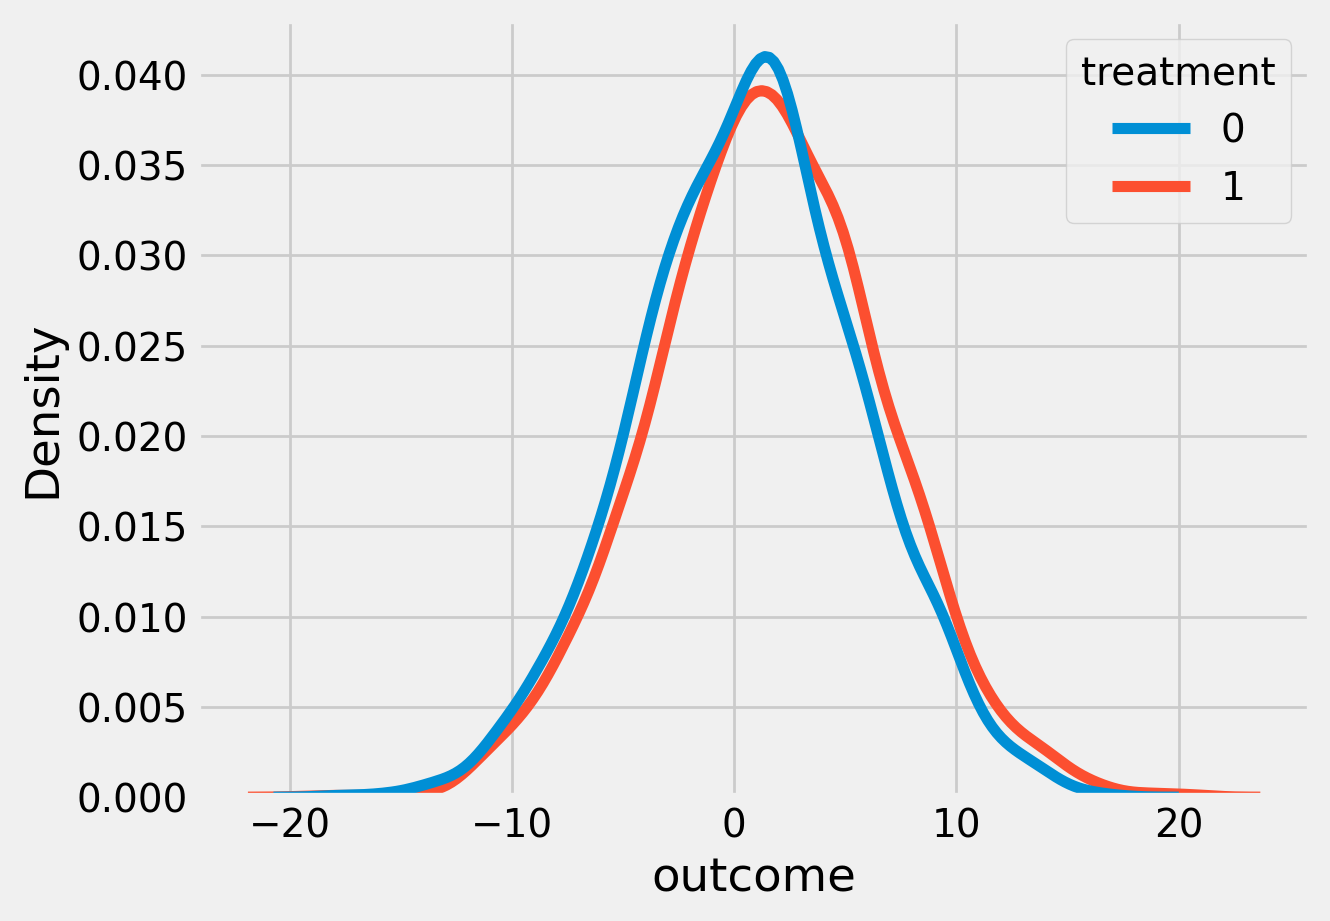

In [6]:
sns.kdeplot(data=df, x='outcome', hue='treatment')
plt.show()

In [7]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
n_test = df_test.shape[0]
n_train = df_train.shape[0]

In [8]:
# Table to gather estimated ITEs by models
df_result = pd.DataFrame({
    'outcome': df_test['outcome'],
    'is_treated': df_test['treatment'],
    'treatment_effect': df_test['treatment_effect']
})

### CausalTreeRegressor

Available criteria for causal trees:

`standard_mse`: scikit-learn MSE where node values store $E_{node_i}(X|T=1)-E_{node_i}(X|T=0)$, treatment effects.

`causal_mse`: *The criteria reward a partition for finding strong heterogeneity in treatment effects and penalize a partition that creates variance in leaf estimates.*
https://www.pnas.org/doi/10.1073/pnas.1510489113

In [9]:
ctrees = {
    'ctree_mse': {
        'params':
        dict(criterion='standard_mse',
             control_name=0,
             min_impurity_decrease=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
    'ctree_cmse': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=100,
            groups_penalty=0.,
            groups_cnt=True,
        ),
    },
    'ctree_cmse_p=0.1': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.1,
            groups_cnt=True,
        ),
    },
    'ctree_cmse_p=0.25': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.25,
            groups_cnt=True,
        ),
    },
    'ctree_cmse_p=0.5': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'ctree_ttest': {
        'params':
        dict(criterion='t_test',
             control_name=0,
             min_samples_leaf=100,
             groups_penalty=0.,
             groups_cnt=True),
    },
}

In [10]:
# Model treatment effect
for ctree_name, ctree_info in ctrees.items():
    print(f"Fitting: {ctree_name}")
    ctree = CausalTreeRegressor(**ctree_info['params'])
    ctree.fit(X=df_train[feature_names].values,
              treatment=df_train['treatment'].values,
              y=df_train['outcome'].values)
    
    ctrees[ctree_name].update({'model': ctree})
    df_result[ctree_name] = ctree.predict(df_test[feature_names].values)

Fitting: ctree_mse
Fitting: ctree_cmse
Fitting: ctree_cmse_p=0.1
Fitting: ctree_cmse_p=0.25
Fitting: ctree_cmse_p=0.5
Fitting: ctree_ttest


In [11]:
df_result.head()

outcome  is_treated  treatment_effect  ctree_mse  ctree_cmse  \
207   -6.226016           0          2.434805   2.480459    3.346238   
1866   0.722683           0          0.359669   0.036291   -1.979720   
9487   6.190585           1          0.031169   0.346871   -4.619956   
3673  -2.054093           0          1.780163   0.944471    1.674071   
7178  13.723378           1          1.352523   0.747913   -0.851279   

      ctree_cmse_p=0.1  ctree_cmse_p=0.25  ctree_cmse_p=0.5  ctree_ttest  
207           1.593823           1.593823          2.148150     3.090234  
1866          0.423639           0.423639         -0.496591     1.280016  
9487          0.423639           0.423639         -0.600022    -4.619956  
3673          1.744129           1.744129          1.484378    -0.728700  
7178          1.479139           1.479139          0.406058    -0.803791

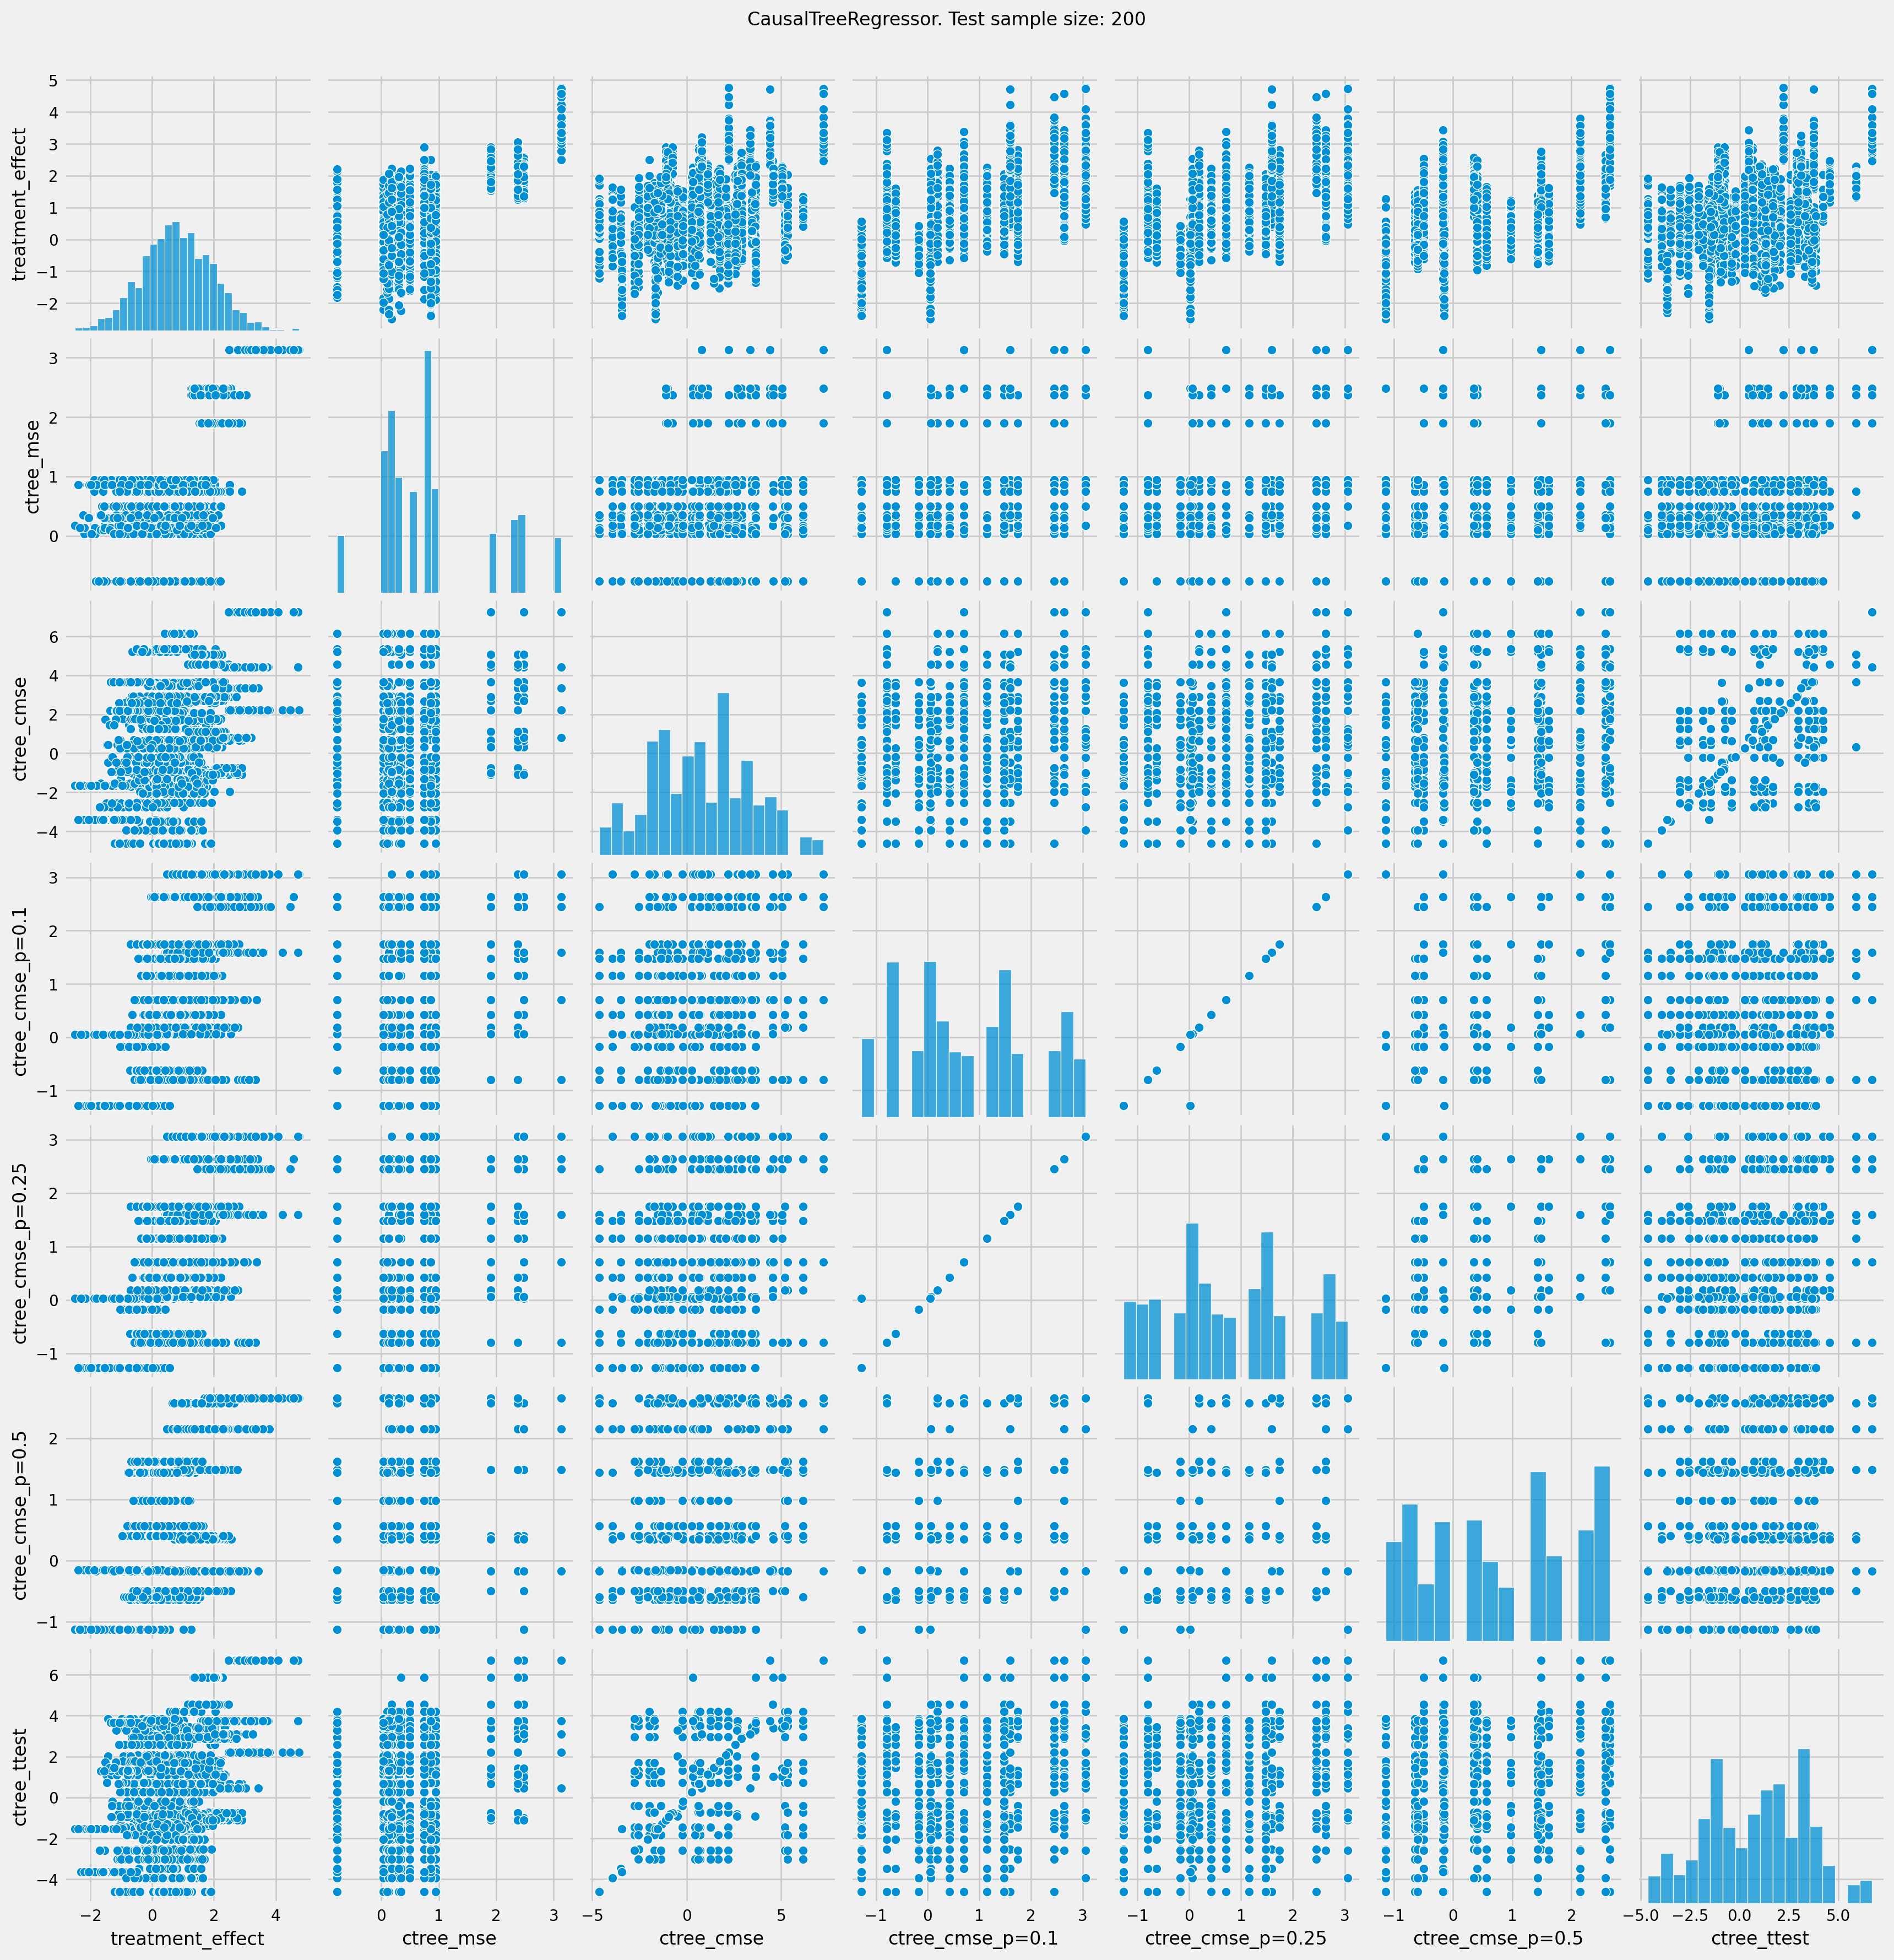

In [12]:
# See treatment effect estimation with CausalTreeRegressor vs true treatment effect

n_obs = 200

indxs = df_result.index.values
np.random.shuffle(indxs)
indxs = indxs[:n_obs]

plt.rcParams.update({'font.size': 10})
pairplot = sns.pairplot(df_result[['treatment_effect', *list(ctrees)]])
pairplot.fig.suptitle(f"CausalTreeRegressor. Test sample size: {n_obs}" , y=1.02)
plt.show()

#### Plot the Qini chart

In [ ]:
plot_qini(df_result,
          outcome_col='outcome',
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
          figsize=(5,5)
         )

In [ ]:
df_qini = qini_score(df_result,
           outcome_col='outcome',
           treatment_col='is_treated',
           treatment_effect_col='treatment_effect')
df_qini.sort_values(ascending=False)

#### The cumulative gain of the true treatment effect in each population

In [ ]:
plot_gain(df_result, 
          outcome_col='outcome', 
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
          n = n_test,
          figsize=(5,5)
         )

#### The cumulative difference between the mean outcomes of the treatment and control groups in each population

In [ ]:
plot_gain(df_result, 
          outcome_col='outcome', 
          treatment_col='is_treated',
          n = n_test,
          figsize=(5,5)
         )

#### Plot trees with sklearn function and save as vector graphics

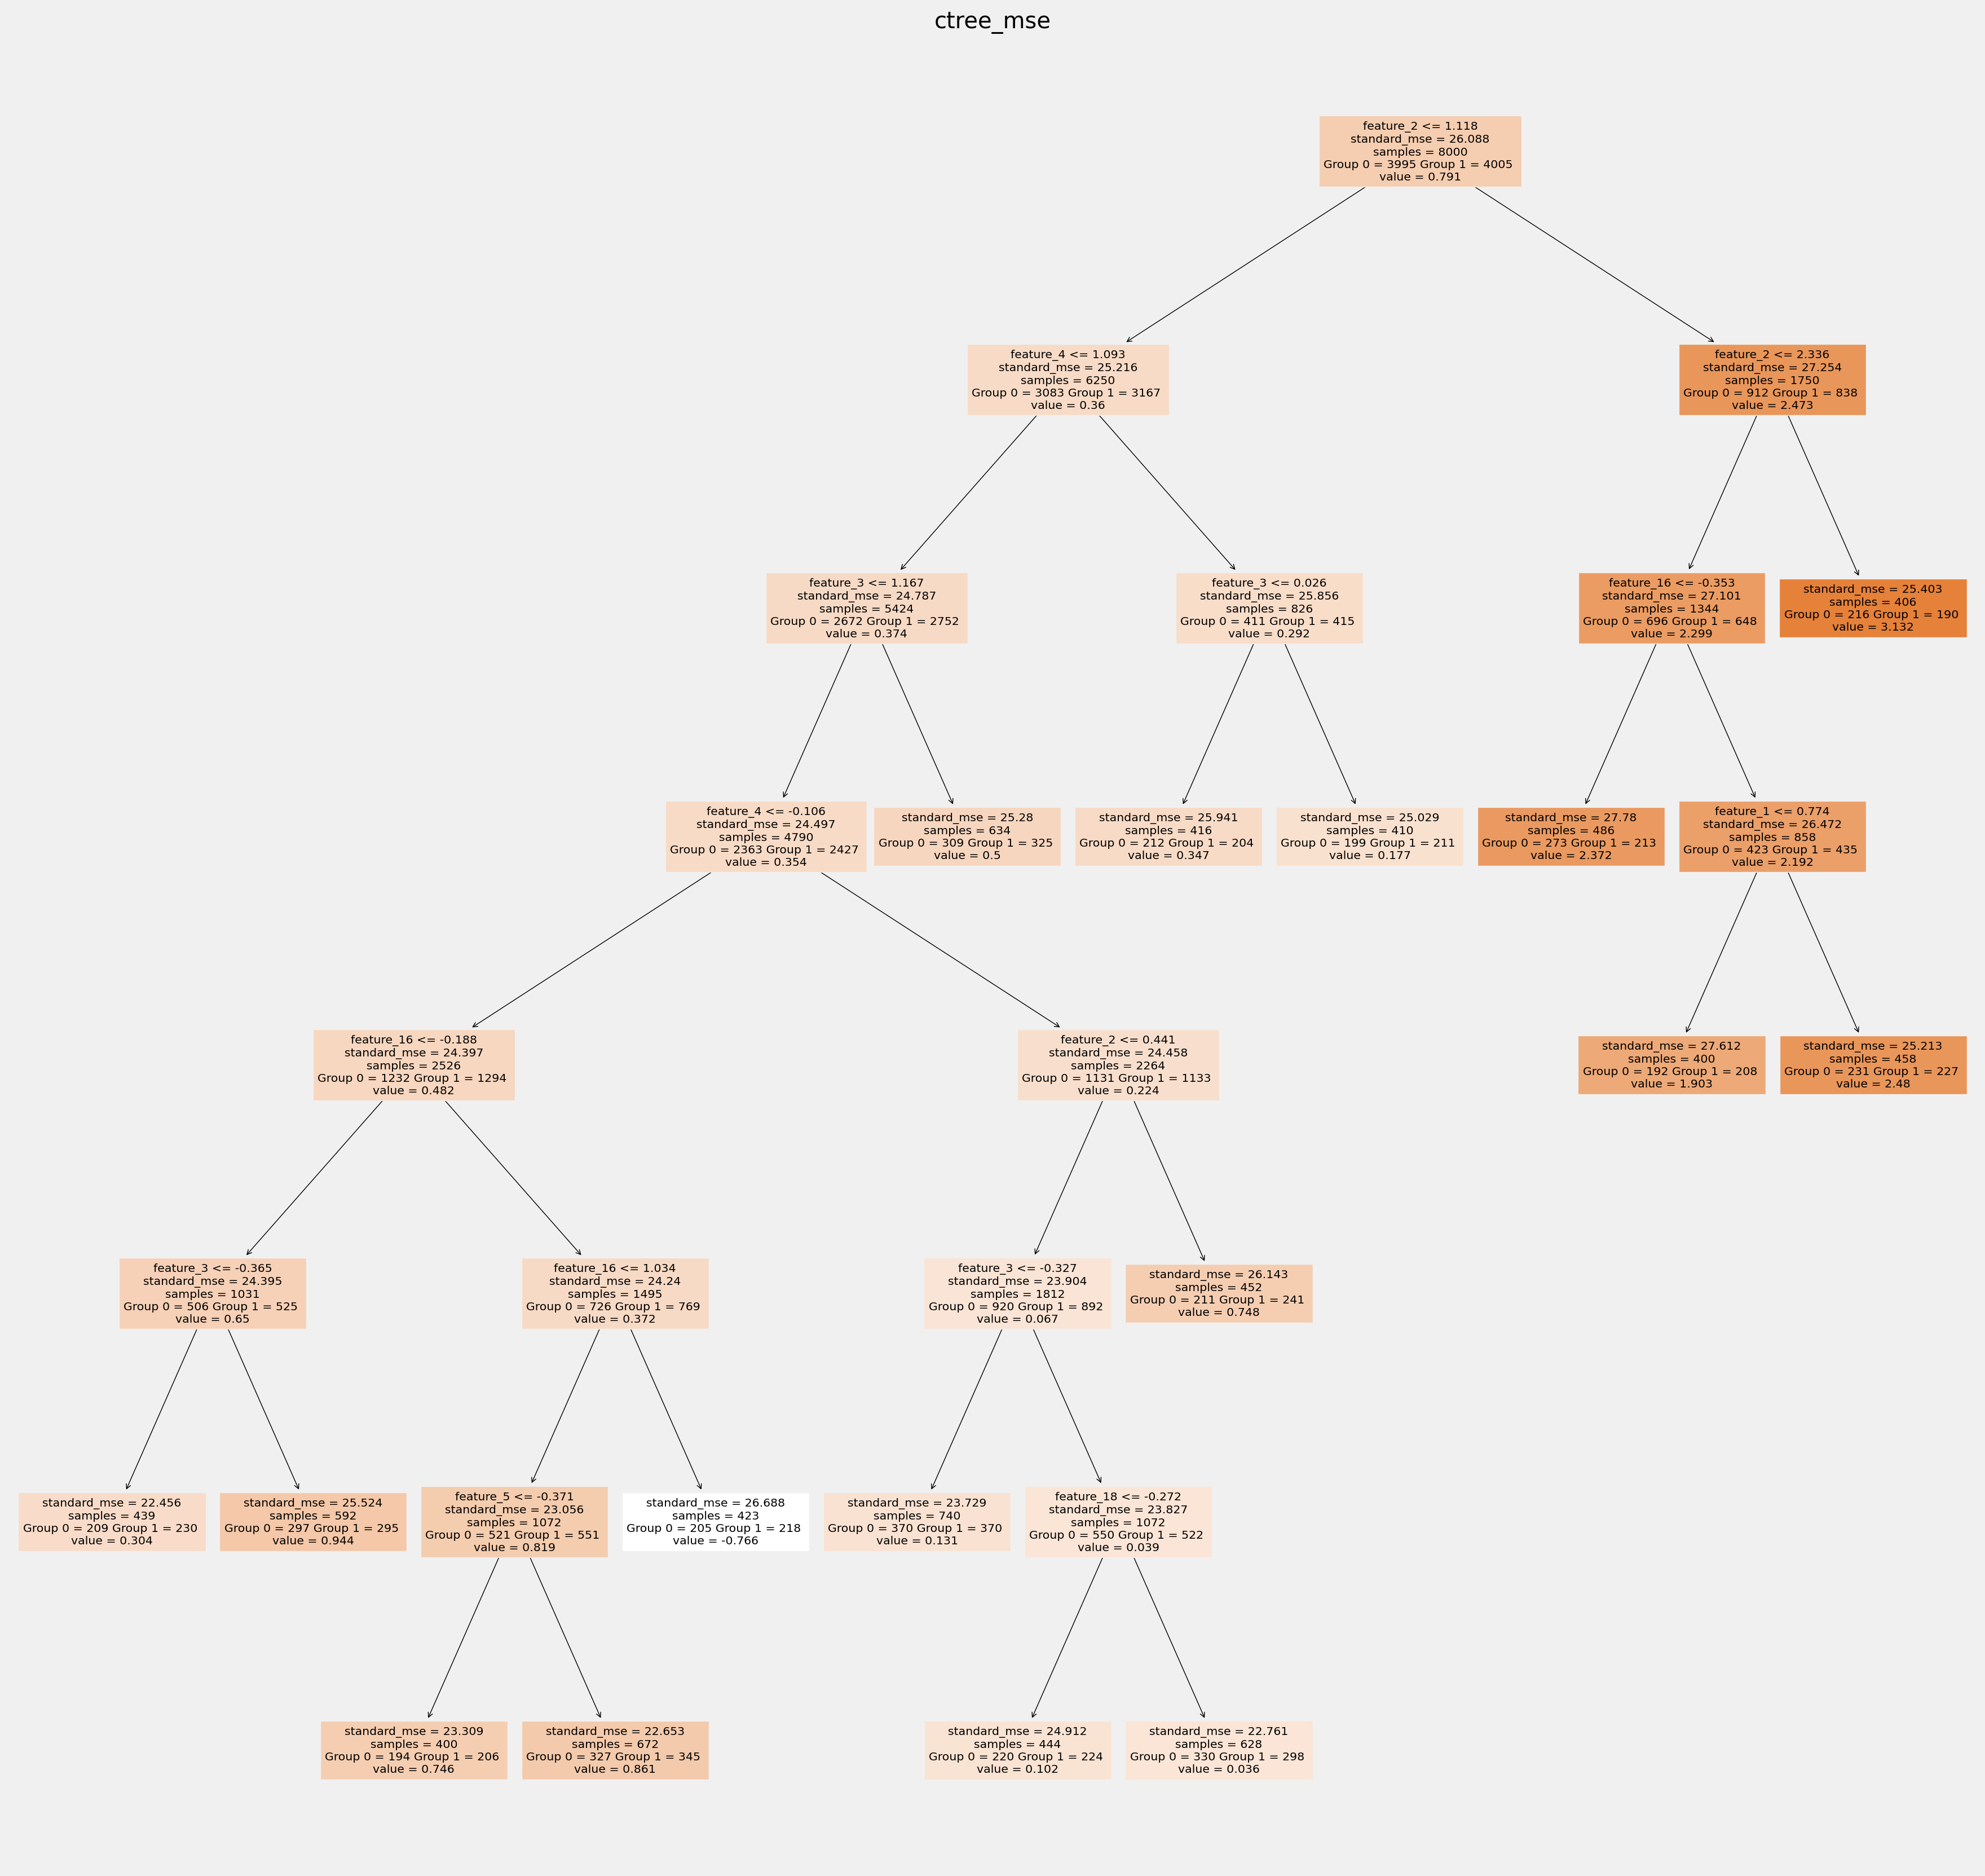

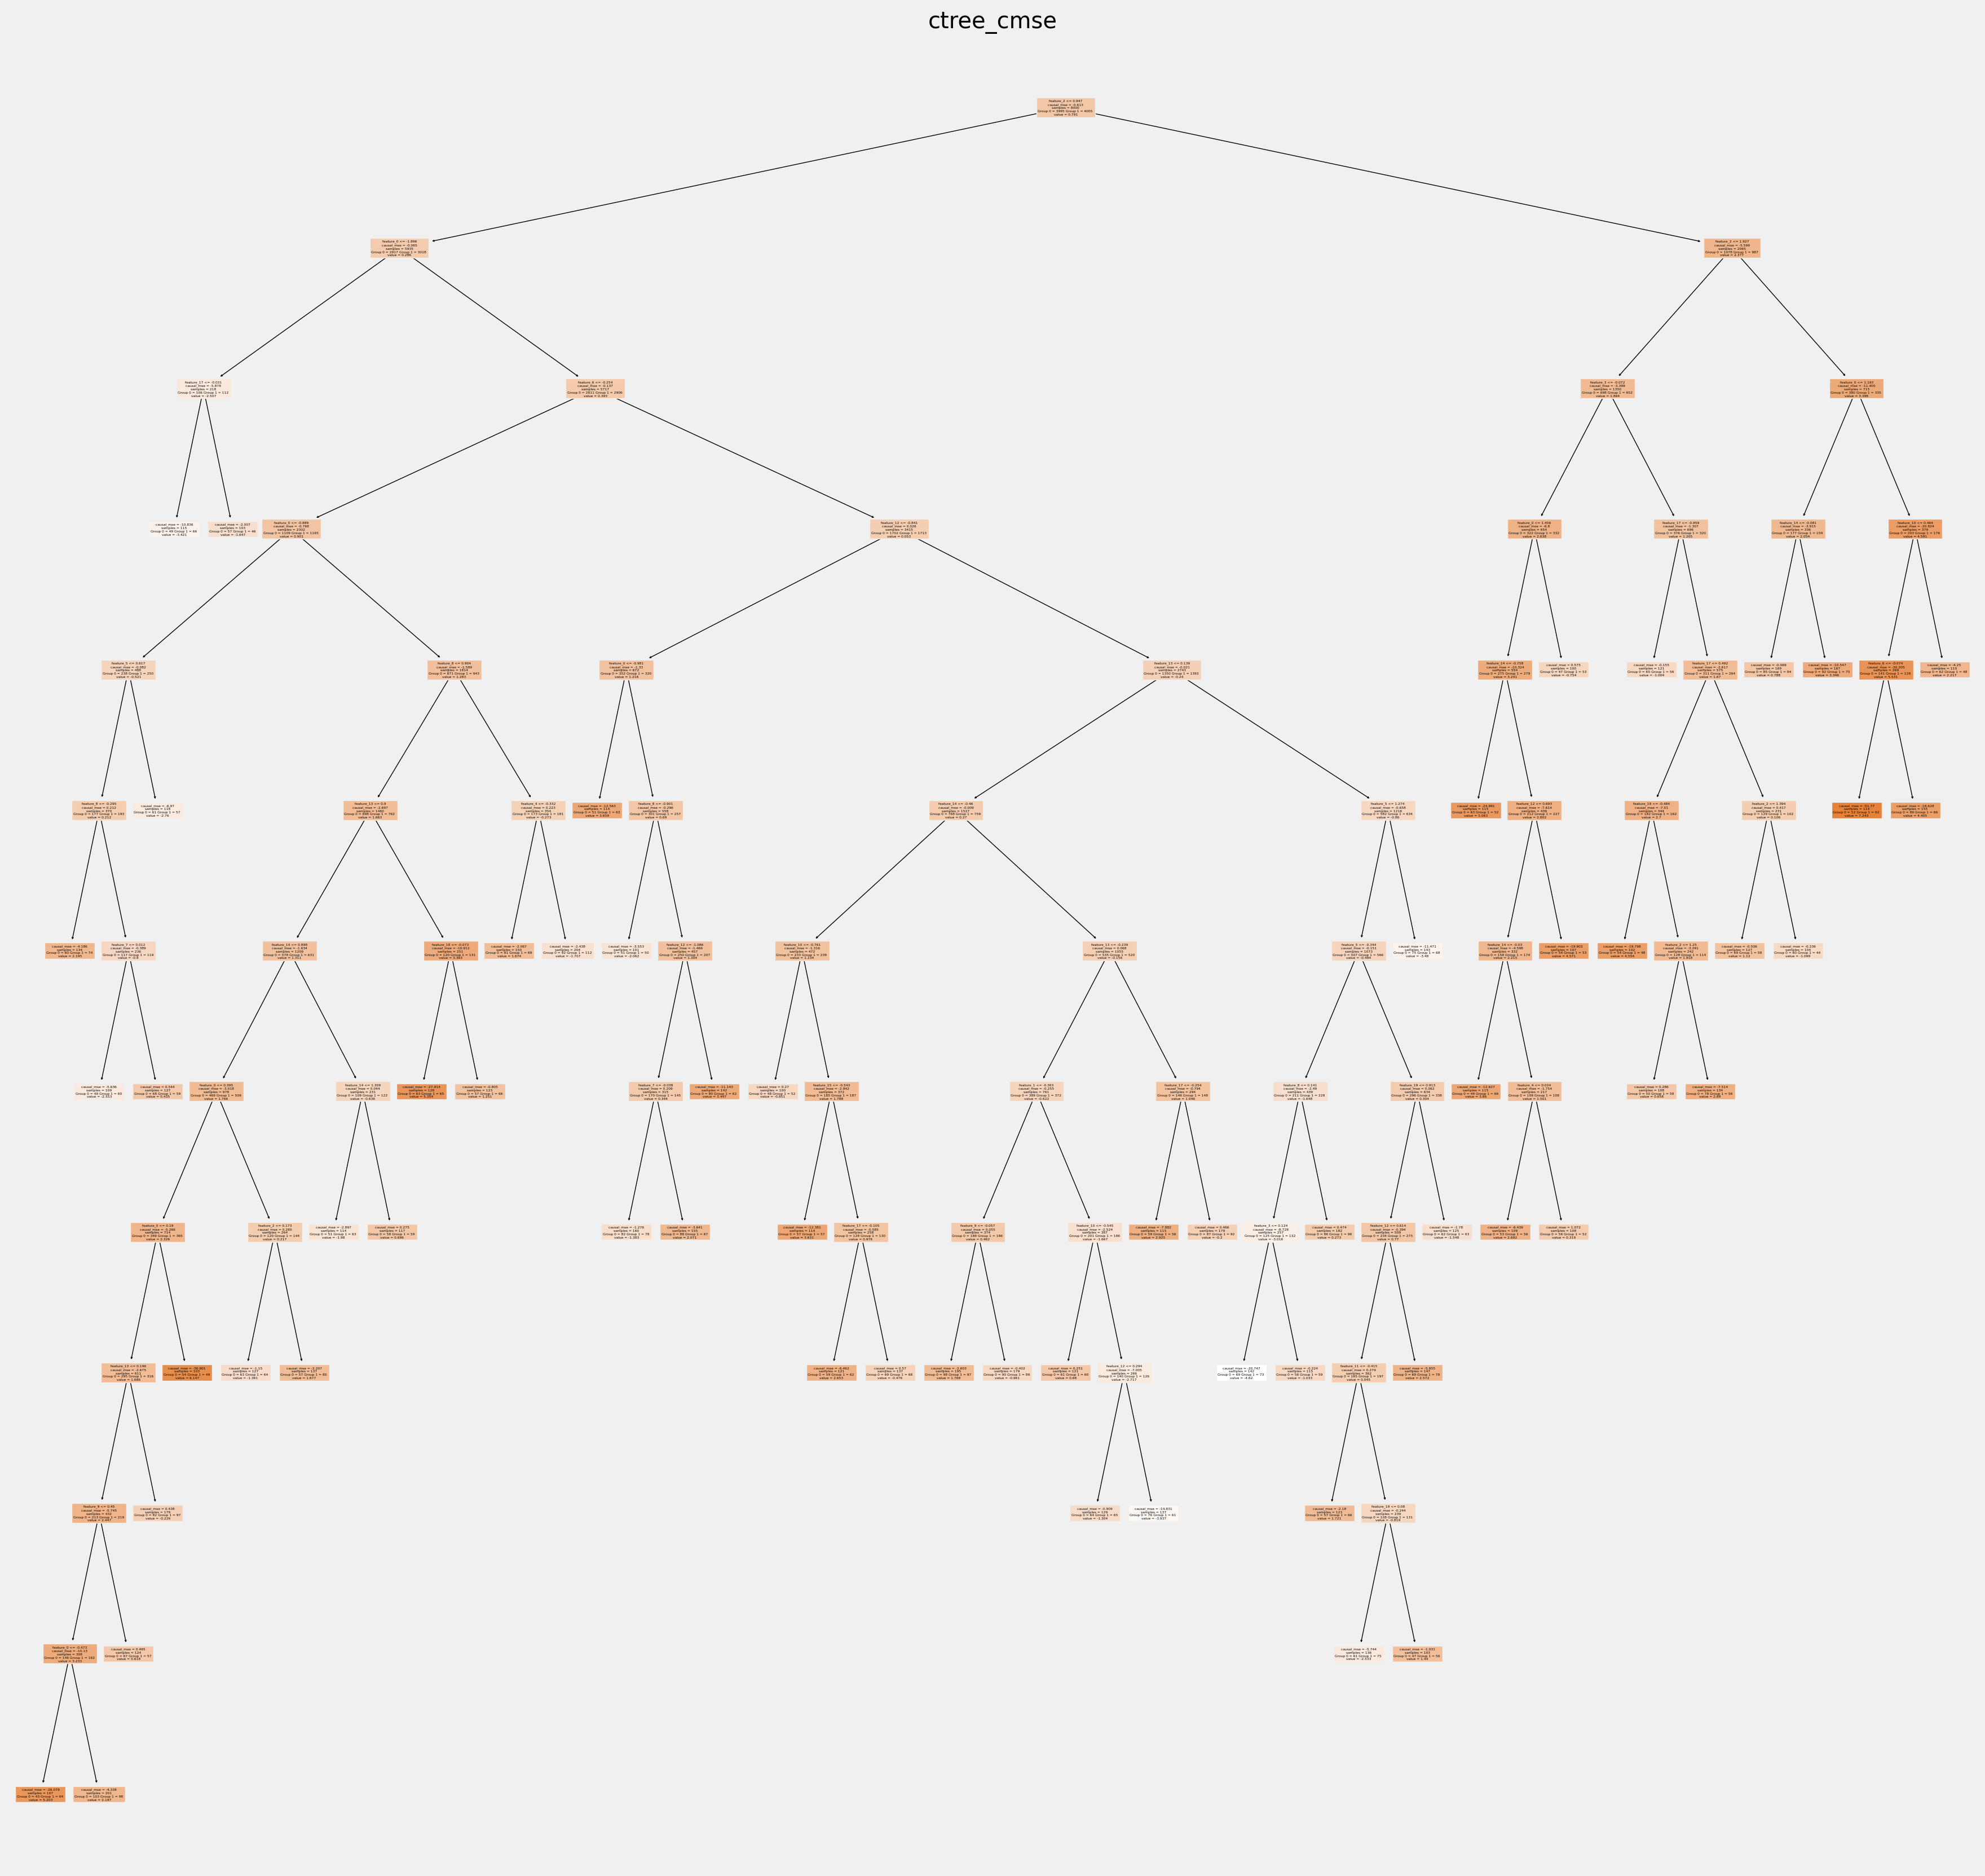

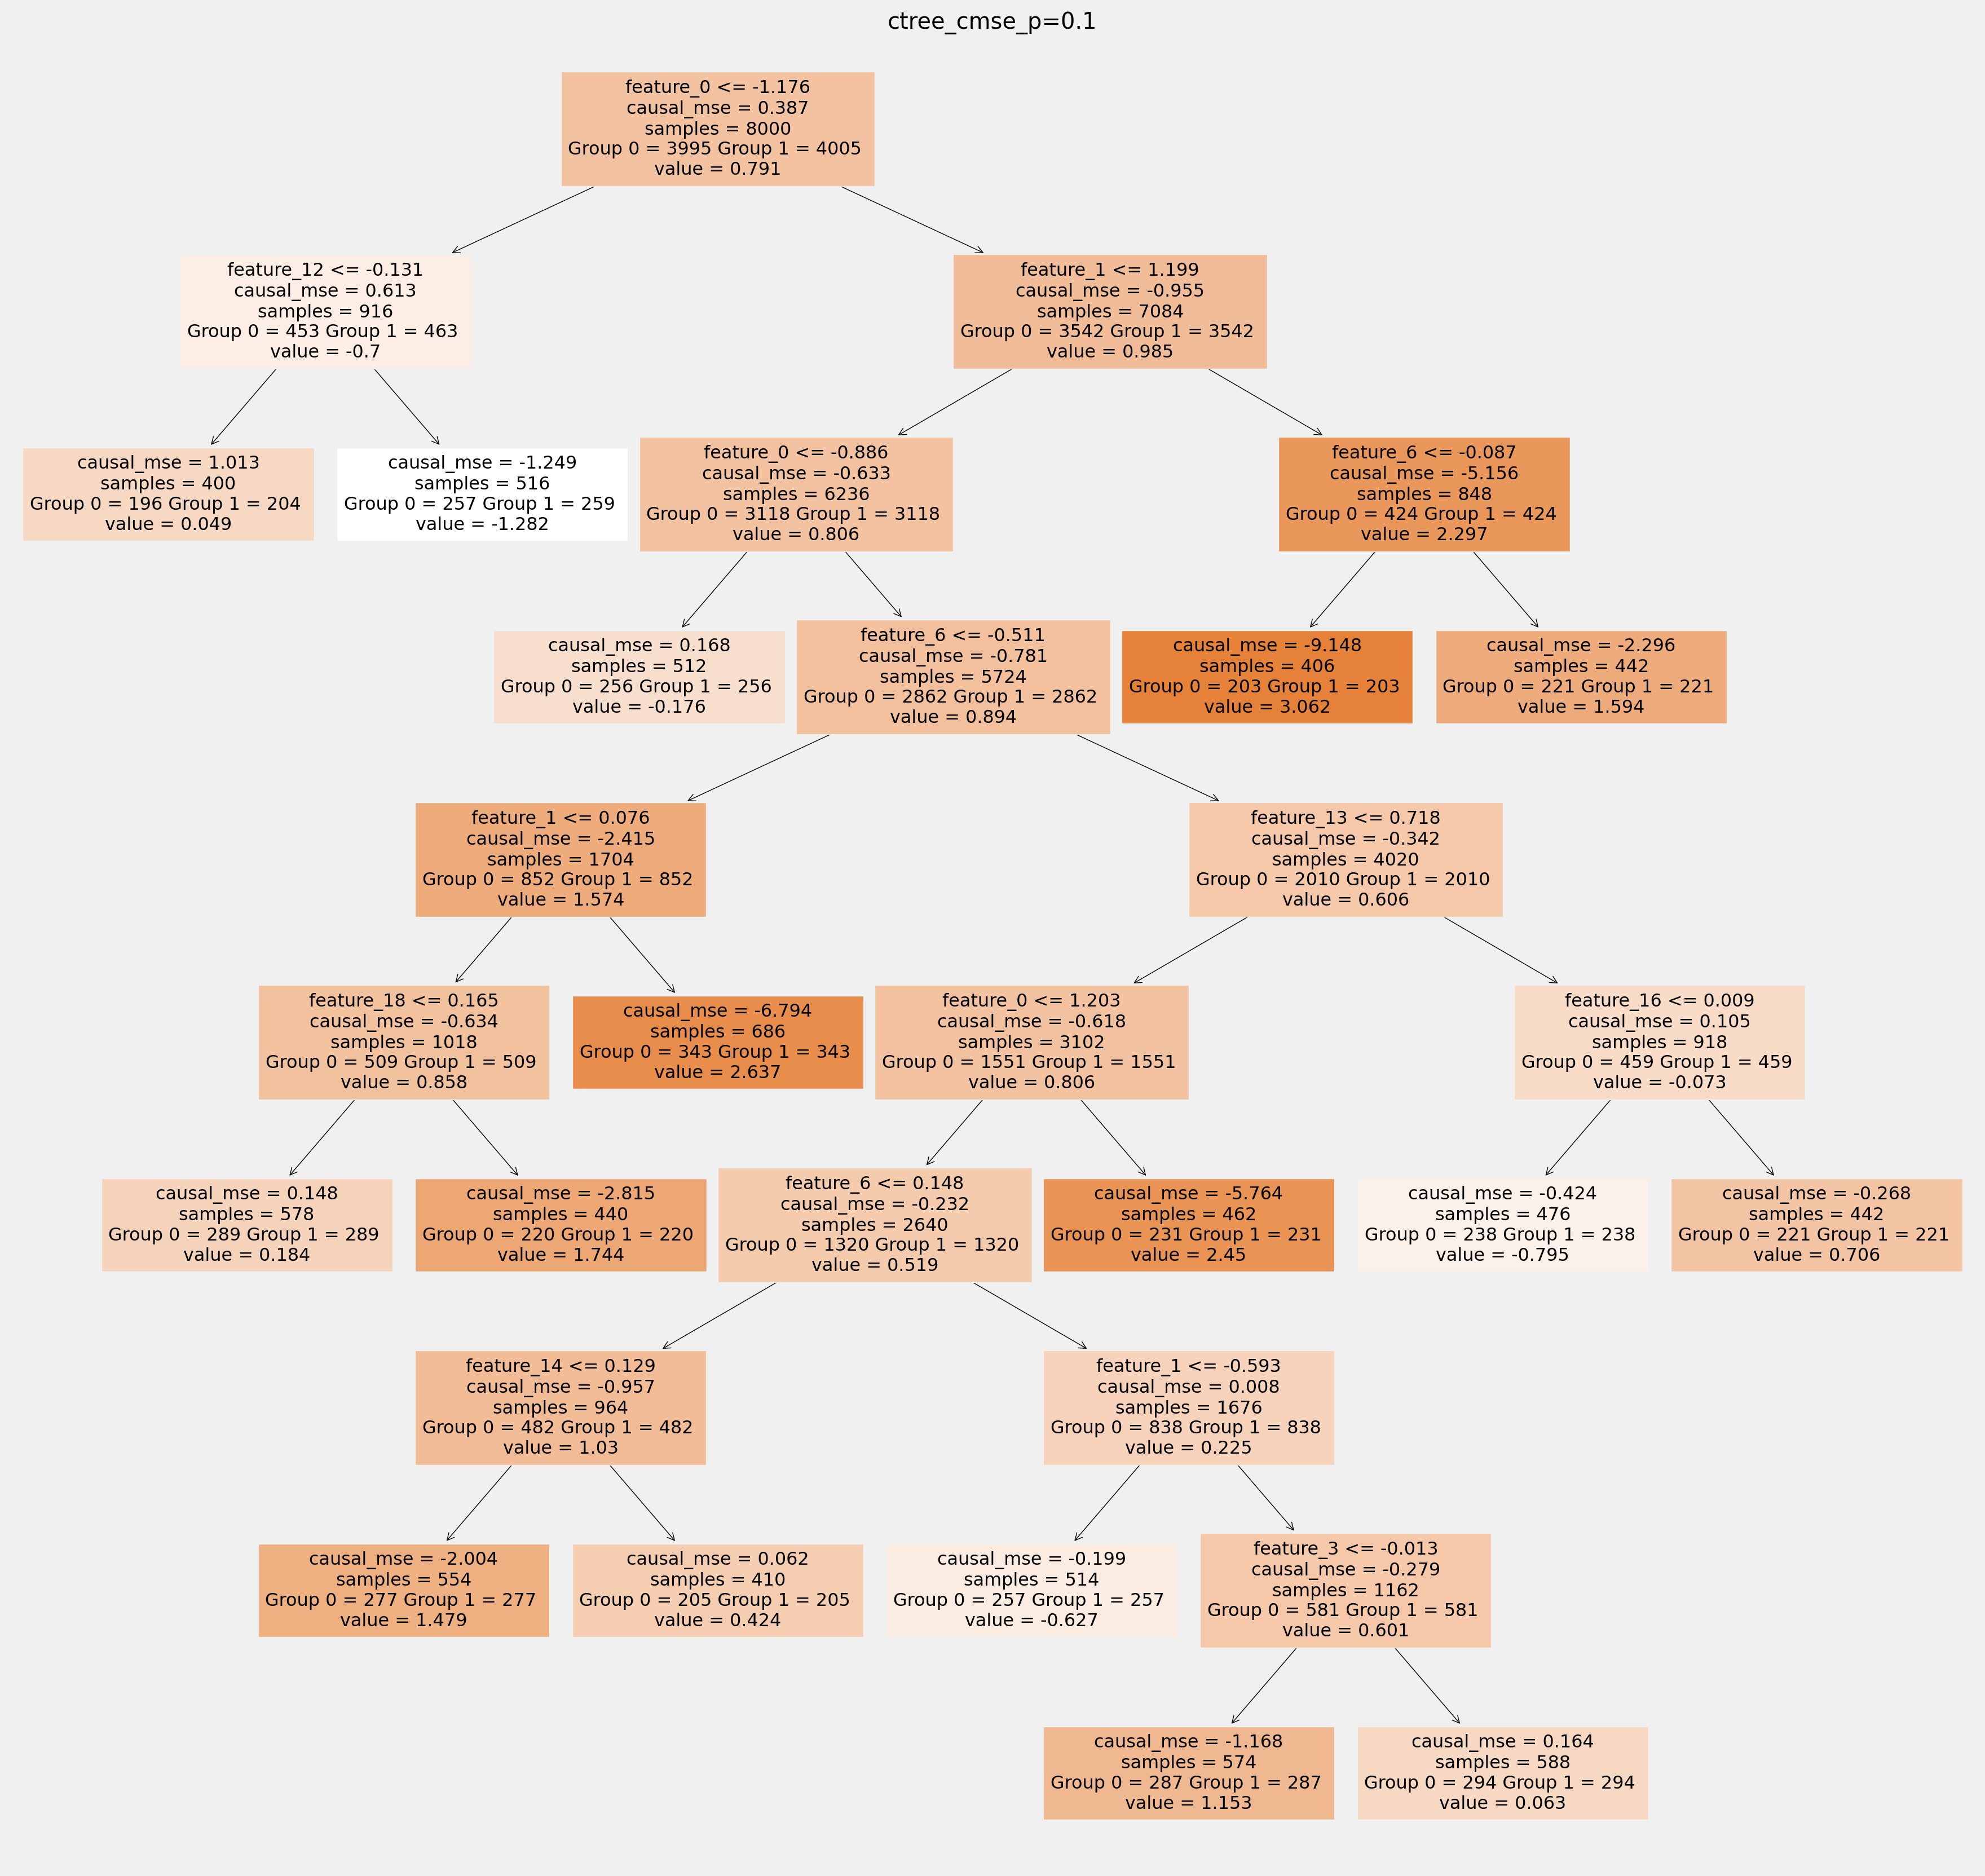

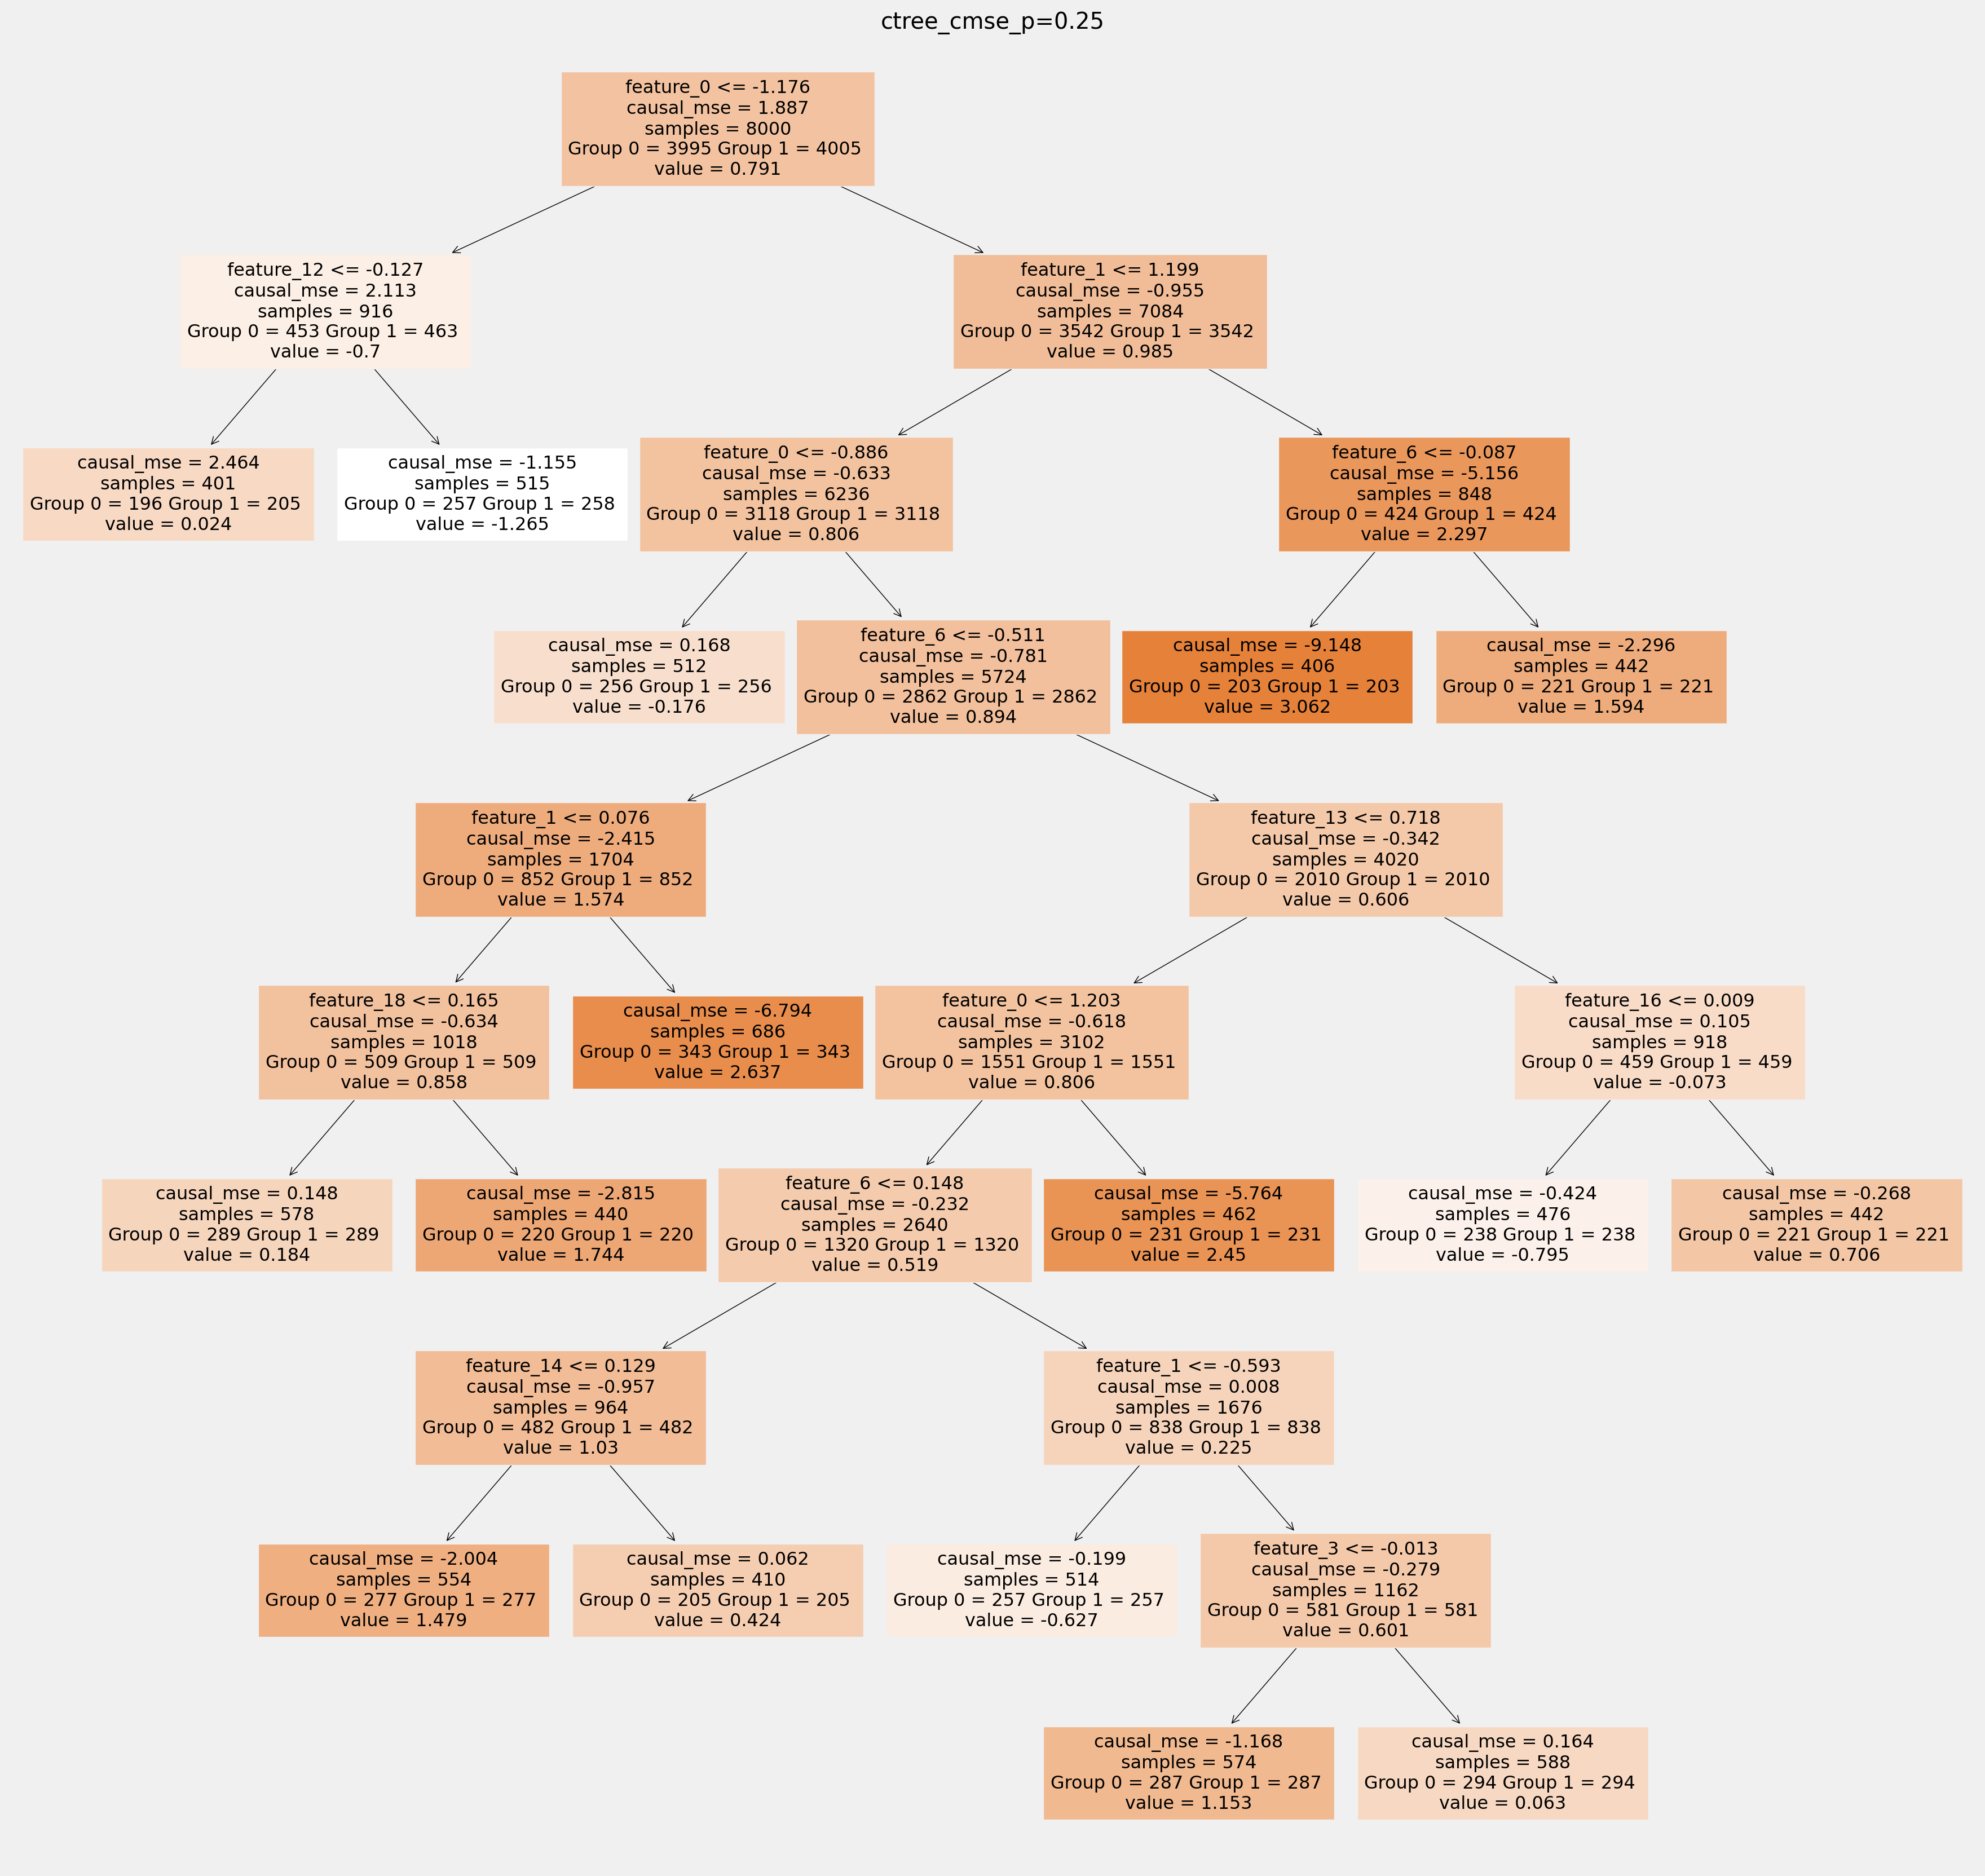

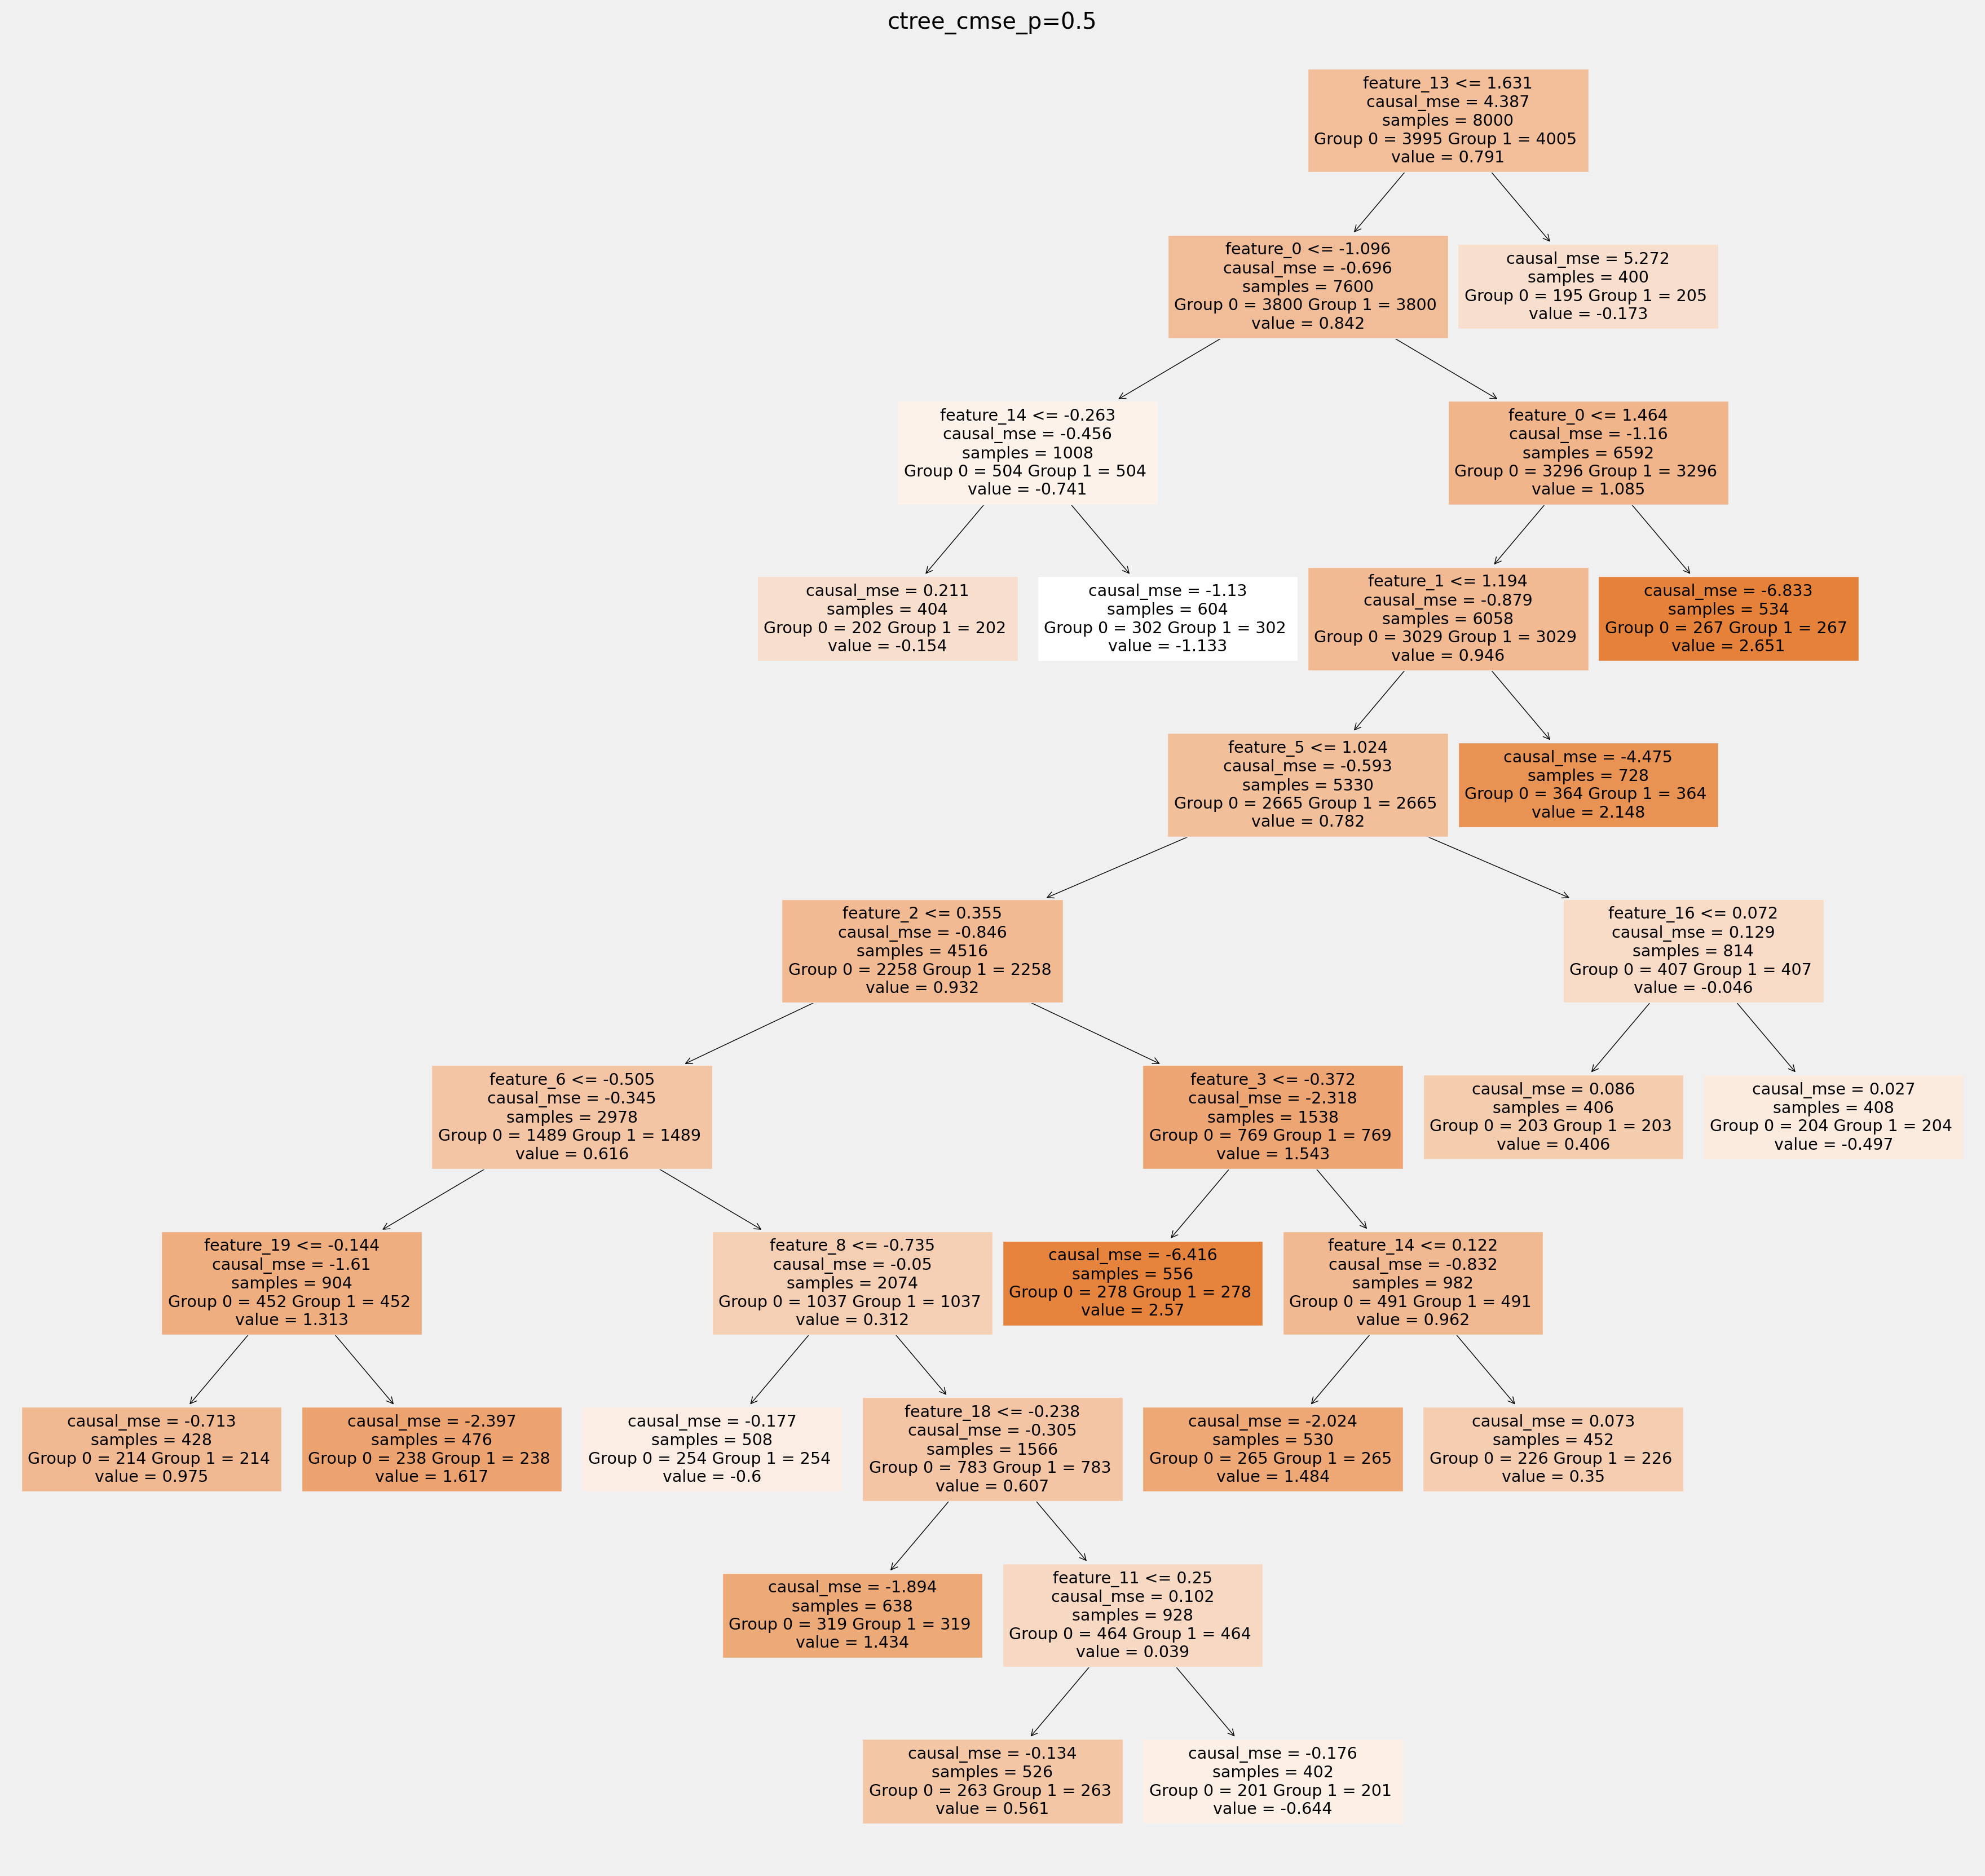

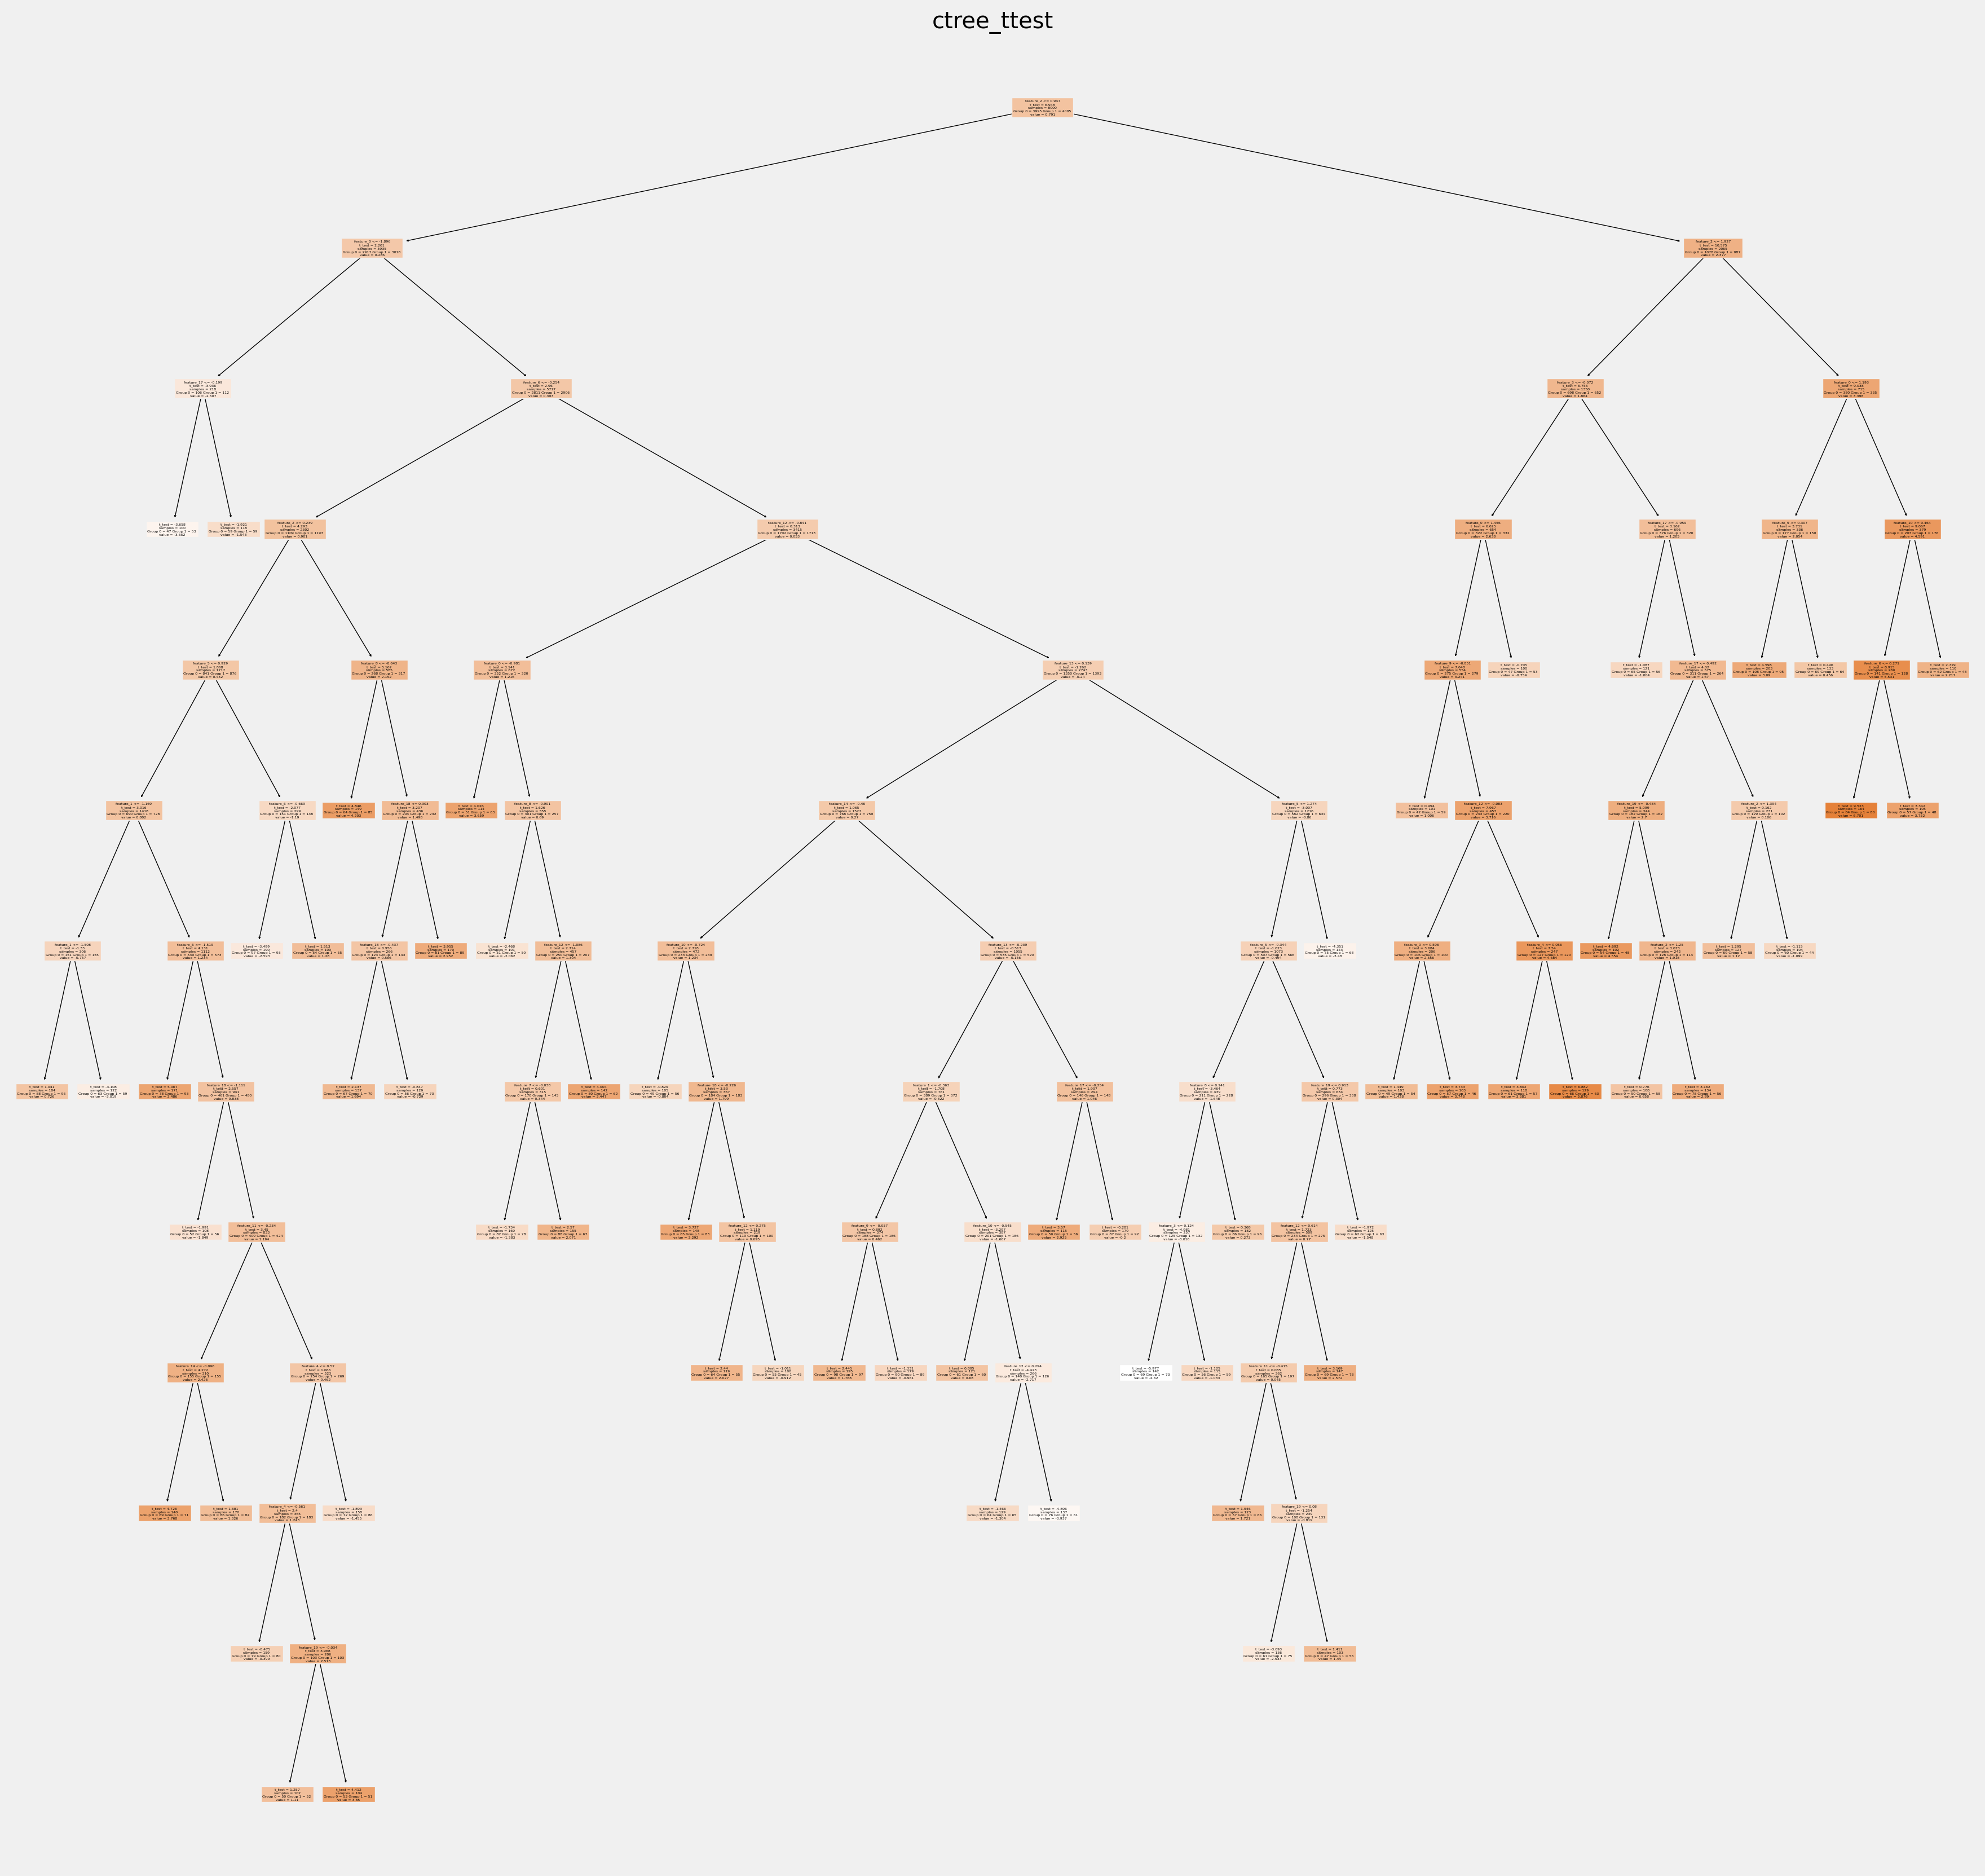

In [13]:
for ctree_name, ctree_info in ctrees.items():
    plt.figure(figsize=(20,20))
    plot_causal_tree(ctree_info['model'], 
                     feature_names = feature_names,
                     filled=True,
                     impurity=True,
                     proportion=False,
              )
    plt.title(ctree_name)
    plt.savefig(f'{ctree_name}.svg')

#### How values in leaves of the fitted trees differ from each other:

In [ ]:
for ctree_name, ctree_info in ctrees.items():
    plot_dist_tree_leaves_values(ctree_info['model'], 
                                 figsize=(3,3),
                                 title=f'Tree({ctree_name}) leaves values distribution')

### CausalRandomForestRegressor 

In [ ]:
cforests = {
    'cforest_mse': {
        'params':
        dict(criterion='standard_mse',
             control_name=0,
             min_impurity_decrease=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
    'cforest_cmse': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.,
            groups_cnt=True,
            random_state=111003331
        ),
    },
    'cforest_cmse_p=0.5': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'cforest_cmse_p=0.5_md=3': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            max_depth=3,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'cforest_ttest': {
        'params':
        dict(criterion='t_test',
             control_name=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True,
             random_state=111003331),
    },
}

In [ ]:
# Model treatment effect
for cforest_name, cforest_info in cforests.items():
    print(f"Fitting: {cforest_name}")
    cforest = CausalRandomForestRegressor(**cforest_info['params'])
    cforest.fit(X=df_train[feature_names].values,
              treatment=df_train['treatment'].values,
              y=df_train['outcome'].values)
    
    cforests[cforest_name].update({'model': cforest})
    df_result[cforest_name] = cforest.predict(df_test[feature_names].values)

In [ ]:
# See treatment effect estimation with CausalRandomForestRegressor vs true treatment effect 

n_obs = 200

indxs = df_result.index.values
np.random.shuffle(indxs)
indxs = indxs[:n_obs]

plt.rcParams.update({'font.size': 10})
pairplot = sns.pairplot(df_result[['treatment_effect', *list(cforests)]])
pairplot.fig.suptitle(f"CausalRandomForestRegressor. Test sample size: {n_obs}" , y=1.02)
plt.show()

In [ ]:
df_qini = qini_score(df_result,
           outcome_col='outcome',
           treatment_col='is_treated',
           treatment_effect_col='treatment_effect')

df_qini.sort_values(ascending=False)

#### Qini chart

In [ ]:
plot_qini(df_result,
          outcome_col='outcome',
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
          figsize=(8,8)
         )

In [ ]:
df_qini = qini_score(df_result,
           outcome_col='outcome',
           treatment_col='is_treated',
           treatment_effect_col='treatment_effect')

df_qini.sort_values(ascending=False)

#### The cumulative gain of the true treatment effect in each population

In [ ]:
plot_gain(df_result, 
          outcome_col='outcome', 
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
          n = n_test
         )

#### The cumulative difference between the mean outcomes of the treatment and control groups in each population

In [ ]:
plot_gain(df_result, 
          outcome_col='outcome', 
          treatment_col='is_treated',
          n = n_test
         )

###  Meta-Learner Algorithms

In [ ]:
X_train = df_train[feature_names].values
X_test = df_test[feature_names].values

# learner - DecisionTreeRegressor
# treatment learner - LinearRegression()

learner_x = BaseXRegressor(learner=DecisionTreeRegressor(), 
                           treatment_effect_learner=LinearRegression())
learner_s = BaseSRegressor(learner=DecisionTreeRegressor())
learner_t = BaseTRegressor(learner=DecisionTreeRegressor(), 
                           treatment_learner=LinearRegression())
learner_dr = BaseDRRegressor(learner=DecisionTreeRegressor(), 
                             treatment_effect_learner=LinearRegression())

learner_x.fit(X=X_train, treatment=df_train['treatment'].values, y=df_train['outcome'].values)
learner_s.fit(X=X_train, treatment=df_train['treatment'].values, y=df_train['outcome'].values)
learner_t.fit(X=X_train, treatment=df_train['treatment'].values, y=df_train['outcome'].values)
learner_dr.fit(X=X_train, treatment=df_train['treatment'].values, y=df_train['outcome'].values)

df_result['learner_x_ite'] = learner_x.predict(X_test)
df_result['learner_s_ite'] = learner_s.predict(X_test)
df_result['learner_t_ite'] = learner_t.predict(X_test)
df_result['learner_dr_ite'] = learner_dr.predict(X_test)

In [ ]:
cate_dr = learner_dr.predict(X)
cate_x = learner_x.predict(X)
cate_s = learner_s.predict(X)
cate_t = learner_t.predict(X)

cate_ctrees = [info['model'].predict(X) for _, info in ctrees.items()]
cate_cforests = [info['model'].predict(X) for _, info in cforests.items()]

model_cate = [
    *cate_ctrees,
    *cate_cforests,
    cate_x, cate_s, cate_t, cate_dr
]

model_names = [
    *list(ctrees), *list(cforests),
    'X Learner', 'S Learner', 'T Learner', 'DR Learner']

In [ ]:
plot_gain(df_result, 
          outcome_col='outcome', 
          treatment_col='is_treated',
          n = n_test
         )

In [ ]:
rows = 2
cols = 7
row_idxs = np.arange(rows)
col_idxs = np.arange(cols)

ax_idxs = np.dstack(np.meshgrid(col_idxs, row_idxs)).reshape(-1, 2) 

In [ ]:
fig, ax = plt.subplots(rows, cols, figsize=(20, 10))
plt.rcParams.update({'font.size': 10})

for ax_idx, cate, model_name in zip(ax_idxs, model_cate, model_names):
    col_id, row_id = ax_idx
    cur_ax = ax[row_id, col_id]
    cur_ax.scatter(tau, cate, alpha=0.3)
    cur_ax.plot(tau, tau, color='C2', linewidth=2)
    cur_ax.set_xlabel('True ITE')
    cur_ax.set_ylabel('Estimated ITE')
    cur_ax.set_title(model_name)
    cur_ax.set_xlim((-4, 6))

#### The cumulative difference between the mean outcomes of the treatment and control groups in each population

In [ ]:
plot_gain(df_result, 
          outcome_col='outcome', 
          treatment_col='is_treated',
          n = n_test,
          figsize=(9, 9),
         )

#### Qini chart

In [ ]:
plot_qini(df_result,
          outcome_col='outcome',
          treatment_col='is_treated',
          treatment_effect_col='treatment_effect',
         )

In [ ]:
df_qini = qini_score(df_result,
           outcome_col='outcome',
           treatment_col='is_treated',
           treatment_effect_col='treatment_effect')
df_qini.sort_values(ascending=False)

---

### Bootstrap confidence intervals for individual treatment effects

In [ ]:
alpha=0.05
tree = CausalTreeRegressor(criterion='causal_mse', control_name=0, min_samples_leaf=200, alpha=alpha)

In [ ]:
# For time measurements
for n_jobs in (4, mp.cpu_count() - 1):
    for n_bootstraps in (10, 50, 100):
        print(f"n_jobs: {n_jobs} n_bootstraps: {n_bootstraps}" )
        tree.bootstrap_pool(
            X=X,
            treatment=w,
            y=y,
            n_bootstraps=n_bootstraps,
            bootstrap_size=10000,
            n_jobs=n_jobs,
            verbose=False
        )

In [ ]:
te, te_lower, te_upper = tree.fit_predict(
        X=df_train[feature_names].values,
        treatment=df_train["treatment"].values,
        y=df_train["outcome"].values,
        return_ci=True,
        n_bootstraps=500,
        bootstrap_size=5000,
        n_jobs=mp.cpu_count() - 1,
        verbose=False)

In [ ]:
plt.hist(te_lower, color='red', alpha=0.3, label='lower_bound')
plt.axvline(x = 0, color = 'black', linestyle='--', lw=1, label='')
plt.legend()
plt.show()

In [ ]:
# Significant estimates for negative and positive individual effects
# Default alpha = 0.05

bootstrap_neg = te[(te_lower < 0) & (te_upper < 0)]
bootstrap_pos = te[(te_lower > 0) & (te_upper > 0)]
print(bootstrap_neg.shape, bootstrap_pos.shape)

In [ ]:
plt.hist(bootstrap_neg)
plt.title(f'Bootstrap-based subsample of significant negative ITE. alpha={alpha}')
plt.show()

plt.hist(bootstrap_pos)
plt.title(f'Bootstrap-based subsample of significant positive ITE alpha={alpha}')
plt.show()

### Average treatment effect

In [ ]:
tree = CausalTreeRegressor(criterion='causal_mse', control_name=0, min_samples_leaf=200, alpha=alpha)
te, te_lb, te_ub = tree.estimate_ate(X=X, treatment=w, y=y)
print('ATE:', te, 'Bounds:', (te_lb, te_ub ), 'alpha:', alpha)

### CausalRandomForestRegressor ITE std

In [ ]:
crforest = CausalRandomForestRegressor(criterion="causal_mse",  min_samples_leaf=200,
                                       control_name=0, n_estimators=50, n_jobs=mp.cpu_count()-1)
crforest.fit(X=df_train[feature_names].values,
             treatment=df_train['treatment'].values,
             y=df_train['outcome'].values
             )

In [ ]:
crforest_te_pred = crforest.predict(df_test[feature_names])
crforest_test_var = crforest.calculate_error(X_train=df_train[feature_names].values,
                                        X_test=df_test[feature_names].values)
crforest_test_std = np.sqrt(crforest_test_var)

In [ ]:
plt.hist(crforest_test_std)
plt.title("CausalRandomForestRegressor unbiased sampling std")
plt.show()